<h1>IPL Cricket Data Analysis Project</h1>
<p>The project analyzes IPL cricket data using <strong>PySpark</strong> to perform a series of data <strong>transformations</strong> and <strong>SQL queries</strong>. Our goal is to extract valuable insights and create impactful <strong>visualizations</strong> that illuminate the dynamics of this exciting sport.</p>





In [ ]:
from pyspark.sql import SparkSession

#create session
spark = SparkSession.builder.appName("IPL Data Analysis").getOrCreate()

In [ ]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [ ]:
# Imports necessary libraries and functions
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType
from pyspark.sql.functions import col, when, sum, avg, row_number
from pyspark.sql.window import Window
from pyspark.sql.functions import year, month, dayofmonth, col, when
from pyspark.sql.functions import lower, regexp_replace
from pyspark.sql.functions import current_date
import matplotlib.pyplot as plt
import seaborn as sns


### Defining dataframe schemas

In [ ]:
# Define the schema for the ball-by-ball data
ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", StringType(), True),
    StructField("team_bowling", StringType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", BooleanType(), True),
    StructField("bowled", BooleanType(), True),
    StructField("run_out", BooleanType(), True),
    StructField("lbw", BooleanType(), True),
    StructField("retired_hurt", BooleanType(), True),
    StructField("stumped", BooleanType(), True),
    StructField("caught_and_bowled", BooleanType(), True),
    StructField("hit_wicket", BooleanType(), True),
    StructField("obstructingfeild", BooleanType(), True),
    StructField("bowler_wicket", IntegerType(), True),
    StructField("match_date", DateType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", BooleanType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", DateType(), True)
])

In [ ]:
# Define the schema for the match data
match_schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", DateType(), True),
    StructField("season_year", IntegerType(), True), 
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])

In [ ]:
# Define the schema for the player data
player_schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True)
])

In [ ]:
# Define the schema for the player_match data
player_match_schema = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", DecimalType(10, 2), True),  # Adjust precision and scale as necessary
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),
    StructField("player_team", StringType(), True),
    StructField("opposit_team", StringType(), True),
    StructField("season_year", IntegerType(), True),  
    StructField("is_manofthematch", BooleanType(), True),
    StructField("age_as_on_match", IntegerType(), True),
    StructField("isplayers_team_won", BooleanType(), True),
    StructField("batting_status", StringType(), True),
    StructField("bowling_status", StringType(), True),
    StructField("player_captain", StringType(), True),
    StructField("opposit_captain", StringType(), True),
    StructField("player_keeper", StringType(), True),
    StructField("opposit_keeper", StringType(), True)
])

In [ ]:
# Define the schema for the team data
team_schema = StructType([
    StructField("team_sk", IntegerType(), True),
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True)
])

### Reading the datasets from Amazon S3 bucket

In [ ]:
ball_by_ball_df = spark.read.schema(ball_by_ball_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Ball_By_Ball.csv")

match_df = spark.read.schema(match_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Match.csv")

player_df = spark.read.schema(player_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Player.csv")

player_match_df = spark.read.schema(player_match_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Player_match.csv")

team_df = spark.read.schema(team_schema).format("csv").option("header","true").load("s3://samiksha-khare-projects/ipl-dataset-analysis/Team.csv")

### Data transformations

In [ ]:

# Filter to include only valid deliveries (excluding extras- like white and no balls for specific analysis)
ball_by_ball_df = ball_by_ball_df.filter((col("wides")==0) & (col("noballs")==0))

# Aggregation: calculate the total and average runs scored in each match and innings
total_and_avg_runs = ball_by_ball_df.groupBy("match_id","innings_no").agg(
    sum("runs_scored").alias("total_runs"),
    avg("runs_scored").alias("average_runs"),
)

total_and_avg_runs.orderBy('match_id','innings_no').show(10)

+--------+----------+----------+------------------+
|match_id|innings_no|total_runs|      average_runs|
+--------+----------+----------+------------------+
|  335987|         1|       205|1.7083333333333333|
|  335987|         2|        63|0.6923076923076923|
|  335988|         1|       230|1.9166666666666667|
|  335988|         2|       196|1.6333333333333333|
|  335989|         1|       118|0.9833333333333333|
|  335989|         2|       122|1.3406593406593406|
|  335990|         1|       154|1.2833333333333334|
|  335990|         2|       161|1.3644067796610169|
|  335991|         1|       100|0.8928571428571429|
|  335991|         2|        84|0.7368421052631579|
+--------+----------+----------+------------------+
only showing top 10 rows



In [ ]:
# Window function: Calculate runnung total of runs in each match for each over
windowFunction = Window.partitionBy("match_id","innings_no").orderBy("over_id")

running_total_runs = ball_by_ball_df.withColumn(
    "running_toal_runs_each_over", 
    sum("runs_scored").over(windowFunction)
)

In [ ]:
# Show running total of match number 335987 to verify
runs_per_match_per_inns_per_over = running_total_runs.select("match_id", "over_id","innings_no","running_toal_runs_each_over").orderBy("match_id","innings_no")
# runs_per_match_per_inns_per_over.where(runs_per_match_per_inns_per_over.match_id == 335987).show(240

In [ ]:
# Conditional column flag for high impact balls (either a wicket or more than 6 runs including extras)
ball_by_ball_df = ball_by_ball_df.withColumn(
    "high_impact",
    when( (col("runs_scored") + col("extra_runs") > 6) | (col("bowler_wicket") == 1),True).otherwise(False)
)

ball_by_ball_df.select("match_id", "over_id", "runs_scored", "extra_runs","bowler_wicket","high_impact").where(ball_by_ball_df.high_impact == True).orderBy("match_id", "over_id").show(10)

+--------+-------+-----------+----------+-------------+-----------+
|match_id|over_id|runs_scored|extra_runs|bowler_wicket|high_impact|
+--------+-------+-----------+----------+-------------+-----------+
|  335987|      2|          0|         0|            1|       true|
|  335987|      3|          0|         0|            1|       true|
|  335987|      5|          0|         0|            1|       true|
|  335987|      6|          0|         0|            1|       true|
|  335987|      6|          0|         0|            1|       true|
|  335987|      8|          0|         0|            1|       true|
|  335987|      9|          0|         0|            1|       true|
|  335987|      9|          0|         0|            1|       true|
|  335987|     13|          0|         0|            1|       true|
|  335987|     14|          0|         0|            1|       true|
+--------+-------+-----------+----------+-------------+-----------+
only showing top 10 rows



In [ ]:
# Check match_df: column names and its datatype 
# match_df.dtypes

# Extracting year, month and day from the 'match_date' column, for more detailed time-based analysis
match_df = match_df.withColumn("year", year("match_date"))
match_df = match_df.withColumn("month", month("match_date"))
match_df = match_df.withColumn("day", dayofmonth("match_date"))

# High margin wins: categorizing win margins into 'high', 'medium' and 'low' 501270
match_df = match_df.withColumn(
    "margin_wins_impact_category",
    when((col("win_type") == "runs") & (col("win_margin") >= 100), "high")
    .when((col("win_type") == "runs") & (col("win_margin") < 100) & (col("win_margin") >= 50), "medium")
    .when((col("win_type") == "runs") & (col("win_margin") < 50), "low")
    .when((col("win_type") == "wickets") & (col("win_margin") >= 8), "high")
    .when((col("win_type") == "wickets") & (col("win_margin") < 8) & (col("win_margin") >= 4), "medium")
    .when((col("win_type") == "wickets") & (col("win_margin") < 4), "low")
    # .when((col("win_type") == "NO Result"), "unknown")
    .otherwise("unknown")
)

match_df.select("win_type", "win_margin", "margin_wins_impact_category").show(10)

+--------+----------+---------------------------+
|win_type|win_margin|margin_wins_impact_category|
+--------+----------+---------------------------+
|    runs|       140|                       high|
|    runs|        33|                        low|
| wickets|         9|                       high|
| wickets|         5|                     medium|
| wickets|         5|                     medium|
| wickets|         6|                     medium|
| wickets|         9|                       high|
|    runs|         6|                        low|
| wickets|         3|                        low|
|    runs|        66|                     medium|
+--------+----------+---------------------------+
only showing top 10 rows



In [ ]:
# Analyze the impact of the toss: who wins the toss and the match 
match_df = match_df.withColumn(
    "toss_match_winner",
    when((col("toss_winner") == col("match_winner")),"Yes").otherwise("No")
)

match_df.select("toss_winner","match_winner","toss_match_winner").show(10)

+--------------------+--------------------+-----------------+
|         toss_winner|        match_winner|toss_match_winner|
+--------------------+--------------------+-----------------+
|Royal Challengers...|Kolkata Knight Ri...|               No|
| Chennai Super Kings| Chennai Super Kings|              Yes|
|    Rajasthan Royals|    Delhi Daredevils|               No|
|      Mumbai Indians|Royal Challengers...|               No|
|     Deccan Chargers|Kolkata Knight Ri...|               No|
|     Kings XI Punjab|    Rajasthan Royals|               No|
|     Deccan Chargers|    Delhi Daredevils|               No|
|      Mumbai Indians| Chennai Super Kings|               No|
|    Rajasthan Royals|    Rajasthan Royals|              Yes|
|      Mumbai Indians|     Kings XI Punjab|               No|
+--------------------+--------------------+-----------------+
only showing top 10 rows



In [ ]:
# Normalize and clean players name
player_df = player_df.withColumn("player_name", lower(regexp_replace("player_name","[^a-zA-Z0-9 ]","")))

# Handle missing values in batting hand and bowling scale
player_df = player_match_df.na.fill({"batting_hand" : "unknown", "bowling_skill" : "unknown"})

# Categorizing players based on batting hand
player_df = player_df.withColumn(
    "batting_style",
    when(col("batting_hand").contains("Left"), "Left-Handed").otherwise("Right-Handed")
) 
player_df.select("batting_hand", "player_name", "batting_style").show(10)

+--------------+-----------+-------------+
|  batting_hand|player_name|batting_style|
+--------------+-----------+-------------+
|       unknown|        N/A| Right-Handed|
|Right-hand bat|   R Dravid| Right-Handed|
|Right-hand bat|   W Jaffer| Right-Handed|
|Right-hand bat|    V Kohli| Right-Handed|
|Right-hand bat|  JH Kallis| Right-Handed|
|Right-hand bat|   CL White| Right-Handed|
|Right-hand bat| MV Boucher| Right-Handed|
|Right-hand bat|    B Akhil| Right-Handed|
|Right-hand bat|  AA Noffke| Right-Handed|
|Right-hand bat|    P Kumar| Right-Handed|
+--------------+-----------+-------------+
only showing top 10 rows



In [ ]:
# Identify veteran players
player_match_df = player_match_df.withColumn(
    "veteran_status",
    when(col("age_as_on_match") >=35, "veteran").otherwise("non=veteran")
)

### SQL queries

In [ ]:
# Convert dataframe in table for sql query
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")

In [ ]:
# Top scoring batsmen per season
top_scoring_batsmen_per_season = spark.sql("""
SELECT p.player_name, a.season, a.total
FROM (
    SELECT b.striker, b.season, SUM(b.runs_scored) AS total
    FROM ball_by_ball b
    GROUP BY b.striker, b.season
) AS a
JOIN player p ON a.striker = p.player_id
GROUP BY a.season, p.player_name, a.total 
ORDER BY a.season, a.total DESC
""")

top_scoring_batsmen_per_season.show(10)

+-------------+------+-----+
|  player_name|season|total|
+-------------+------+-----+
|     SE Marsh|  2008|  614|
|    G Gambhir|  2008|  532|
|ST Jayasuriya|  2008|  508|
|    SR Watson|  2008|  463|
|     GC Smith|  2008|  437|
| AC Gilchrist|  2008|  431|
|    YK Pathan|  2008|  430|
|     SK Raina|  2008|  420|
|     MS Dhoni|  2008|  414|
|    RG Sharma|  2008|  399|
+-------------+------+-----+
only showing top 10 rows



In [ ]:
# Most economical bowler in powerplay (ie first 6 overs in am match)
economical_powerplay_bowler = spark.sql("""
 SELECT p.player_name, b.bowler, avg(runs_scored) as avg_runs_per_ball
 FROM ball_by_ball b 
 JOIN player p ON b.bowler = p.player_id
 WHERE b.over_id <=6
 GROUP BY b.bowler, p.player_name
 ORDER BY avg_runs_per_ball                                         
                              """)

economical_powerplay_bowler.show(10)

+-----------+------+------------------+
|player_name|bowler| avg_runs_per_ball|
+-----------+------+------------------+
| SM Harwood|   184|0.3333333333333333|
| Ankit Soni|   472|               0.5|
| Avesh Khan|   474|               0.5|
|  GR Napier|   180|               0.5|
|   AJ Finch|   254|               0.5|
|    A Zampa|   430|               0.5|
|   NB Singh|   487|0.5833333333333334|
| AG Murtaza|   286|0.6538461538461539|
|  SB Bangar|    59|0.6666666666666666|
| D du Preez|   189|0.6666666666666666|
+-----------+------+------------------+
only showing top 10 rows



In [ ]:
# Toss impact on match 
toss_impact = spark.sql("""
SELECT match_id, toss_winner, match_winner, toss_name,
    CASE 
        WHEN toss_winner = match_winner THEN 'Won'
        ELSE 'Lost'
    END AS toss_match_impact_outcomes
FROM 
    match
""")

toss_impact.show(10)

+--------+--------------------+--------------------+---------+--------------------------+
|match_id|         toss_winner|        match_winner|toss_name|toss_match_impact_outcomes|
+--------+--------------------+--------------------+---------+--------------------------+
|  335987|Royal Challengers...|Kolkata Knight Ri...|    field|                      Lost|
|  335988| Chennai Super Kings| Chennai Super Kings|      bat|                       Won|
|  335989|    Rajasthan Royals|    Delhi Daredevils|      bat|                      Lost|
|  335990|      Mumbai Indians|Royal Challengers...|      bat|                      Lost|
|  335991|     Deccan Chargers|Kolkata Knight Ri...|      bat|                      Lost|
|  335992|     Kings XI Punjab|    Rajasthan Royals|      bat|                      Lost|
|  335993|     Deccan Chargers|    Delhi Daredevils|      bat|                      Lost|
|  335994|      Mumbai Indians| Chennai Super Kings|    field|                      Lost|
|  335995|

In [ ]:
# Avergae run by a player in matches won by the team
average_runs_in_wins = spark.sql("""
SELECT pm.player_name, AVG(b.runs_scored) AS avg_runs_in_wins
FROM ball_by_ball b 
JOIN player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN match m ON b.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY pm.player_name
order by avg_runs_in_wins desc
""")

average_runs_in_wins.show(10)

+-------------+------------------+
|  player_name|  avg_runs_in_wins|
+-------------+------------------+
|  Rashid Khan|               6.0|
|Shahid Afridi|3.3333333333333335|
|     AN Ahmed|               3.0|
|     BA Bhatt|               3.0|
|      SN Khan|2.5789473684210527|
|   SP Jackson|               2.4|
|Harmeet Singh|2.3333333333333335|
|     Umar Gul|2.3076923076923075|
|   SM Pollock|               2.2|
|      MS Gony|2.1379310344827585|
+-------------+------------------+
only showing top 10 rows



In [ ]:
# maximum and average score at each venue
scores_by_venue = spark.sql("""
SELECT venue_name, a.innings_no, AVG(total_runs) AS average_score, MAX(total_runs) AS highest_score
FROM (
    SELECT b.match_id, b.innings_no, match.venue_name, SUM(b.runs_scored) AS total_runs
    FROM ball_by_ball b
    JOIN match 
    ON b.match_id = match.match_id
    WHERE b.innings_no IN (1, 2) 
    GROUP BY b.match_id, match.venue_name, b.innings_no
    ORDER BY b.match_id
) AS a
GROUP BY venue_name, a.innings_no
ORDER BY venue_name , a.innings_no 
""")

scores_by_venue.show(10)

+--------------------+----------+------------------+-------------+
|          venue_name|innings_no|     average_score|highest_score|
+--------------------+----------+------------------+-------------+
|    Barabati Stadium|         1|             161.0|          221|
|    Barabati Stadium|         2|150.57142857142858|          183|
|   Brabourne Stadium|         1| 167.8181818181818|          196|
|   Brabourne Stadium|         2|             158.0|          203|
|        Buffalo Park|         1|134.66666666666666|          168|
|        Buffalo Park|         2|             112.0|          131|
|De Beers Diamond ...|         1|151.66666666666666|          164|
|De Beers Diamond ...|         2|133.33333333333334|          160|
|Dr DY Patil Sport...|         1|135.58823529411765|          175|
|Dr DY Patil Sport...|         2|127.05882352941177|          180|
+--------------------+----------+------------------+-------------+
only showing top 10 rows



In [ ]:
# Count and sort dismissal types by frequency
dismissal_types = spark.sql("""
SELECT out_type, COUNT(*) AS frequency
FROM ball_by_ball
WHERE out_type NOT IN ("Not Applicable")
GROUP BY out_type
ORDER BY frequency DESC
""")

dismissal_types.show(10)

+--------------------+---------+
|            out_type|frequency|
+--------------------+---------+
|              caught|     3678|
|              bowled|     1382|
|             run out|      744|
|        Keeper Catch|      695|
|                 lbw|      455|
|             stumped|      222|
|   caught and bowled|      211|
|          hit wicket|        9|
|        retired hurt|        9|
|obstructing the f...|        1|
+--------------------+---------+



In [ ]:
# Number of matches played and wins after winning the toss 
team_toss_win_performance = spark.sql("""
SELECT team1, COUNT(*) AS matches_played, SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS wins_after_toss
FROM match
WHERE toss_winner = team1
GROUP BY team1
ORDER BY wins_after_toss DESC
""")

team_toss_win_performance.show(10)

+--------------------+--------------+---------------+
|               team1|matches_played|wins_after_toss|
+--------------------+--------------+---------------+
| Chennai Super Kings|            37|             27|
|      Mumbai Indians|            42|             26|
|Kolkata Knight Ri...|            36|             24|
|Royal Challengers...|            34|             19|
|    Delhi Daredevils|            36|             17|
|    Rajasthan Royals|            25|             16|
|     Kings XI Punjab|            32|             14|
| Sunrisers Hyderabad|            16|              8|
|     Deccan Chargers|            22|              6|
|Rising Pune Super...|             6|              4|
+--------------------+--------------+---------------+
only showing top 10 rows



### Data Visualization 

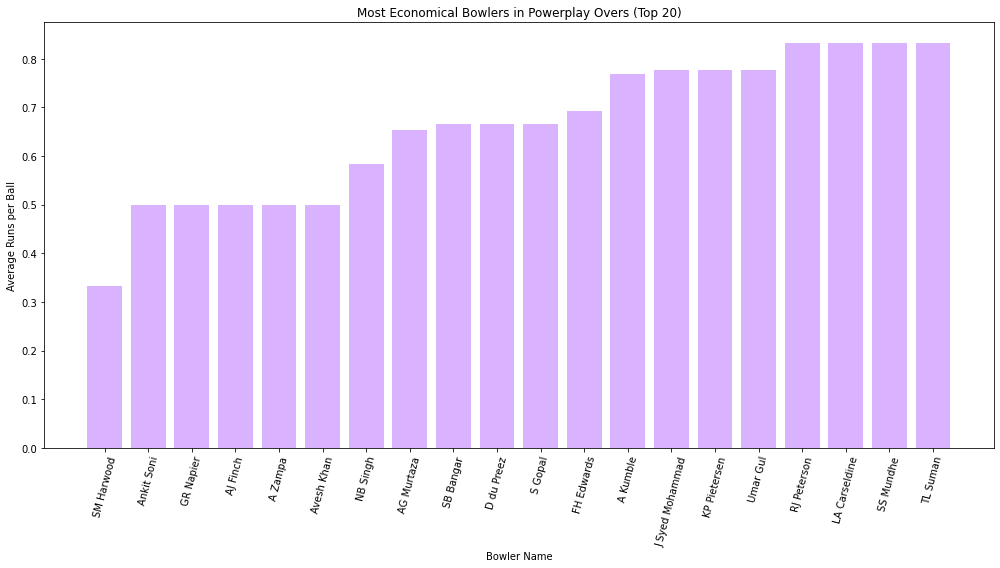

In [ ]:
# Assuming 'economical_bowlers_powerplay' is already executed and available as a Spark DataFrame
economical_bowlers_pd = economical_powerplay_bowler.toPandas()

# Limiting to top 20 for clarity in the plot
top_economical_bowlers = economical_bowlers_pd.nsmallest(20, 'avg_runs_per_ball')

# Create a bar plot using seaborn
plt.figure(figsize=(14, 8))
plt.bar(top_economical_bowlers['player_name'], top_economical_bowlers['avg_runs_per_ball'], color='#d9b3ff')
plt.xlabel('Bowler Name')
plt.ylabel('Average Runs per Ball')
plt.title('Most Economical Bowlers in Powerplay Overs (Top 20)')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

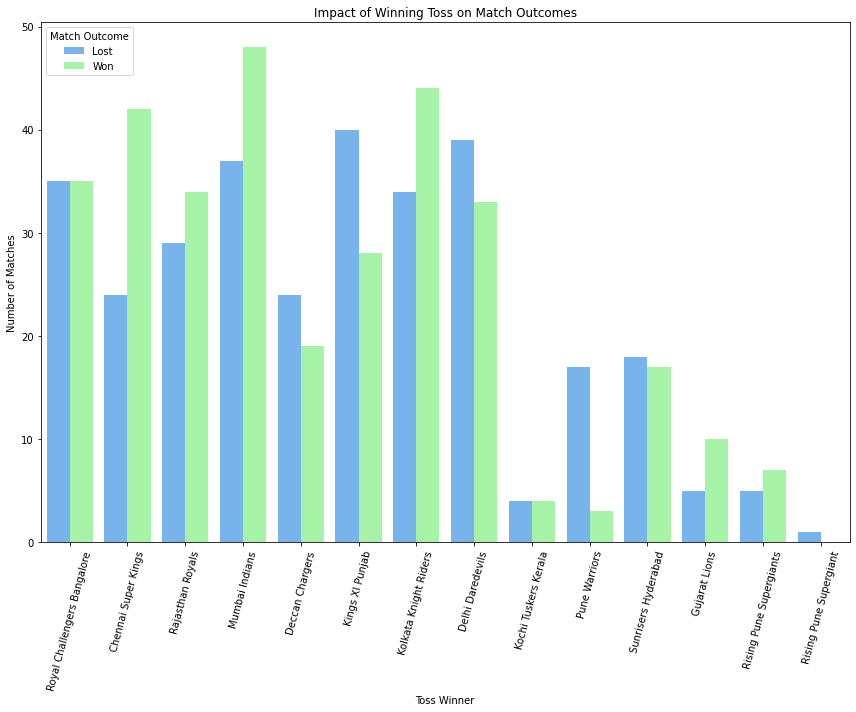

In [ ]:
# Convert the Spark DataFrame 'toss_impact' to a Pandas DataFrame
toss_impact_pd = toss_impact.toPandas()

# Create a countplot using seaborn
plt.figure(figsize=(12, 10))
custom_palette = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']
sns.countplot(x='toss_winner', hue='toss_match_impact_outcomes', data=toss_impact_pd, palette=custom_palette)
plt.title('Impact of Winning Toss on Match Outcomes')
plt.xlabel('Toss Winner')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


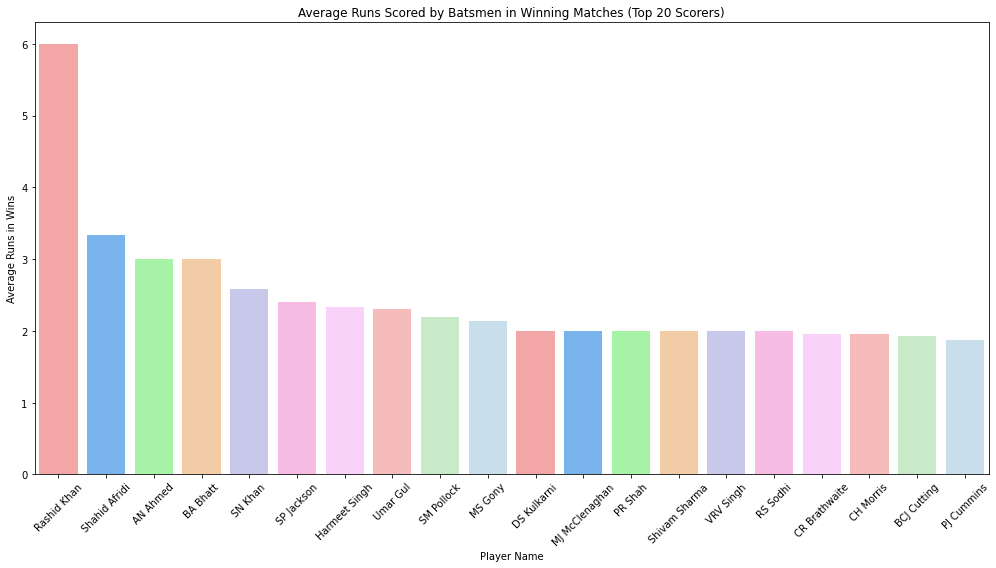

In [ ]:
# Convert the Spark DataFrame 'average_runs_in_wins' to a Pandas DataFrame
average_runs_pd = average_runs_in_wins.toPandas()

# Get the top 20 scorers based on 'avg_runs_in_wins' column using the nlargest function
top_scorers = average_runs_pd.nlargest(20, 'avg_runs_in_wins')

# Create a bar plot using seaborn
plt.figure(figsize=(14, 8))
custom_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ffccff', '#ffb3b3', '#c2f0c2', '#c2e0f0']
sns.barplot(x='player_name', y='avg_runs_in_wins', data=top_scorers, palette=custom_colors)
plt.title('Average Runs Scored by Batsmen in Winning Matches (Top 20 Scorers)')
plt.xlabel('Player Name')
plt.ylabel('Average Runs in Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


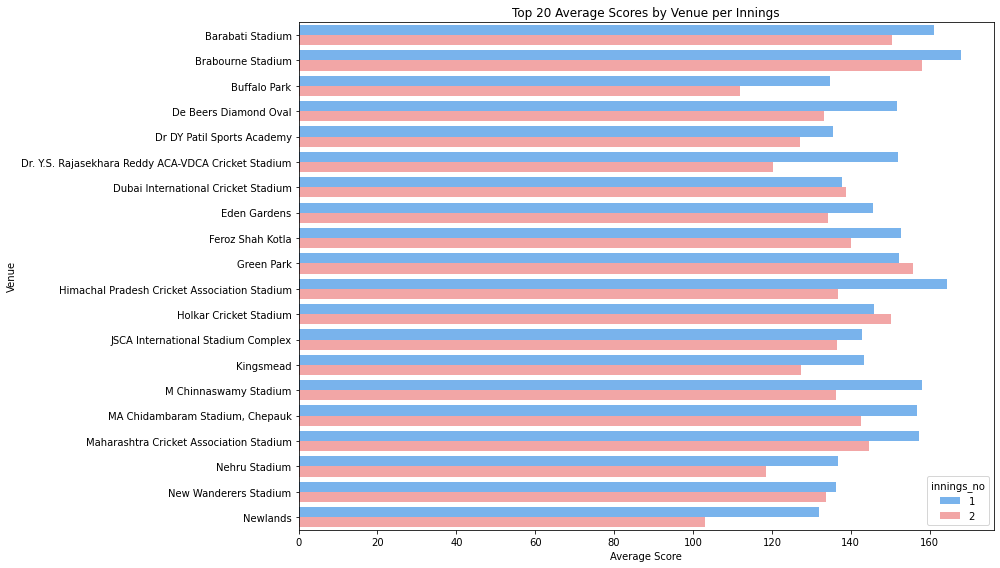

In [ ]:
# Convert Spark DataFrame to Pandas
scores_by_venue_pd = scores_by_venue.toPandas()

# Sort by 'venue_name' and 'innings_no' to group innings 1 and 2 of the same venue together
sorted_scores = scores_by_venue_pd.sort_values(by=['venue_name', 'innings_no'])

# Limit to the top 40 entries (which you are getting from your SQL query)
top_40_scores = sorted_scores.head(40)

# Create the plot
plt.figure(figsize=(14, 8))
custom_palette = ['#66b3ff', '#ff9999']
sns.barplot(x='average_score', y='venue_name', hue='innings_no', data=top_40_scores, palette=custom_palette)
plt.title('Top 20 Average Scores by Venue per Innings')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.tight_layout()
plt.show()


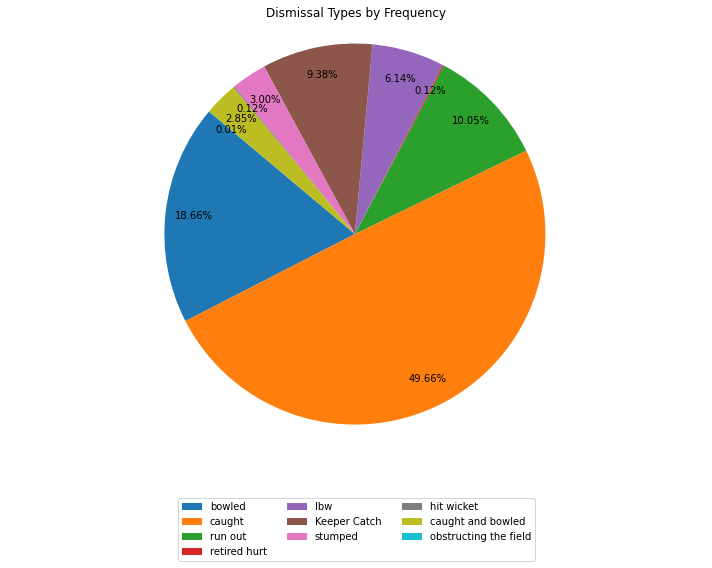

In [ ]:
pd_df = dismissal_types.toPandas()

# # Shuffle the DataFrame rows randomly
pd_df = pd_df.sample(frac=1).reset_index(drop=True)

# Create the pie chart 
plt.figure(figsize=(10, 8))
wedges, _, autotexts = plt.pie(pd_df['frequency'], labels=None, autopct='%1.2f%%', startangle=140, pctdistance=0.85)
plt.title('Dismissal Types by Frequency')
plt.axis('equal')
plt.legend(pd_df['out_type'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3) 
plt.tight_layout()
plt.show()